# Automatic Differentiation with torch.autograd 

신경망 학습은 **역전파(Backpropagation)** 로 손실함수의 기울기(gradient)를 계산한 뒤, 그 기울기에 따라 각 가중치(파라미터)를 업데이트해 손실을 줄이는 방식이다.

gradient = 경사, 기울기 / torch.aitograd를 사용해서 기울기 계산

In [ ]:
import torch

x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

## Tensors, Functions and Computational graph

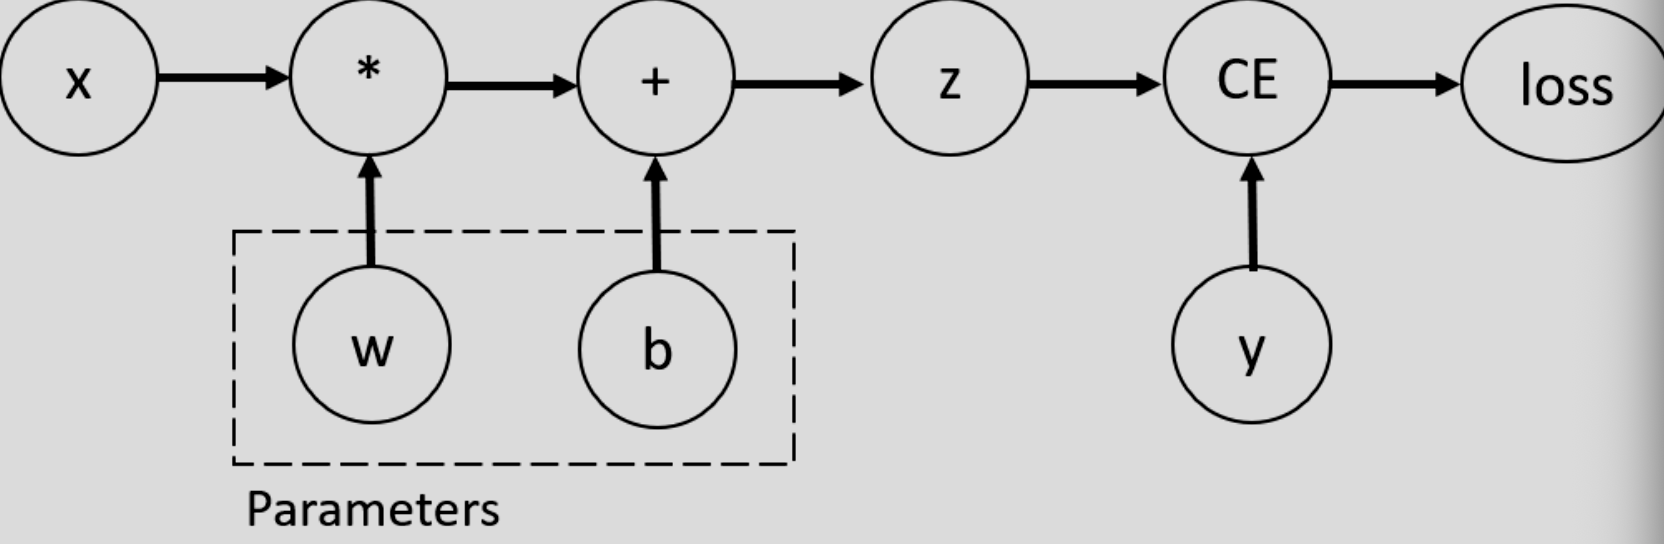



requires_grad=True로 설정하면 해당 텐서에 대한 연산 기록을 추적합니다.

by x.requires_grad_(True) method.

In [ ]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x10c3eb760>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x10c3eacb0>


## Computing Gradients

requires_grad=True로 설정해놓은 것의 grad만 알 수 있다.

In [ ]:
loss.backward() # compute gradients
print(w.grad)
print(b.grad)

tensor([[0.3137, 0.2411, 0.3281],
        [0.3137, 0.2411, 0.3281],
        [0.3137, 0.2411, 0.3281],
        [0.3137, 0.2411, 0.3281],
        [0.3137, 0.2411, 0.3281]])
tensor([0.3137, 0.2411, 0.3281])


## Disabling Gradient Tracking

기울기 트랙킹을 멈추고 싶은 이유

- To mark some parameters in your neural network as frozen parameters.

- To speed up computations when you are only doing forward pass, because computations on tensors that do not track gradients would be more efficient.

forward 연산만하고 싶을 때 torch.no_grad()를 통해서 backword propagation을 tracking하는 것을 멈출 수 있다.

In [6]:
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)

True
False


이렇게도 가능함

detach()

In [7]:
z = torch.matmul(x, w)+b
z_det = z.detach()
print(z_det.requires_grad)

False


## More on Computational Graphs

In a forward pass, autograd does two things simultaneously:

- run the requested operation to compute a resulting tensor

- maintain the operation’s gradient function in the DAG(a directed acyclic graph).

The backward pass kicks off when .backward() is called on the DAG root. autograd then:

- computes the gradients from each .grad_fn,

- accumulates them in the respective tensor’s .grad attribute

- using the chain rule, propagates all the way to the leaf tensors.

## Optional Reading: Tensor Gradients and Jacobian Products

In [8]:
inp = torch.eye(4, 5, requires_grad=True)
out = (inp+1).pow(2).t()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"First call\n{inp.grad}")
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nSecond call\n{inp.grad}")
inp.grad.zero_()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nCall after zeroing gradients\n{inp.grad}")

First call
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])

Second call
tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.]])

Call after zeroing gradients
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])


출력이 스칼라(손실값 1개)면 보통 backward()만 호출해도 “그 1개를 1로 두고” 미분이 정의돼서 각 파라미터의 기울기(gradient)를 구할 수 있어.

그런데 출력이 벡터/행렬처럼 텐서 전체면, “각 원소를 어떻게 합쳐서(어떤 가중치로) 미분할지”가 정해져 있지 않아서 backward()에 같은 모양의 텐서 v를 같이 넣어줘야 해. 이때 PyTorch가 계산하는 건 야코비안(Jacobian) 전체가 아니라, 벡터-야코비안 곱(vector–Jacobian product) 
v
T
J
v 
T
 J이야(= 출력의 각 원소를 v로 가중합한 값을 미분한다고 생각하면 직관적).

코드에서 out.backward(torch.ones_like(out))는 “out의 모든 원소를 1로 가중합(그냥 다 더한 것과 같은 효과)”한 스칼라를 만든 다음, 그 스칼라에 대한 inp의 기울기를 구하는 것과 비슷해.

그리고 backward()를 두 번 호출했을 때 grad가 2배로 커진 이유는, PyTorch가 기본적으로 inp.grad에 기울기를 누적(accumulate) 해서 더해버리기 때문이야. 그래서 매 스텝/매번 새로 기울기를 구하고 싶으면 inp.grad.zero_()처럼 먼저 0으로 초기화해야 하고, 실제 학습에선 옵티마이저가 보통 zero_grad()로 이 작업을 해줘.

마지막으로 “이전엔 backward()에 파라미터를 안 넣었다”는 말은, 출력이 스칼라일 때는 내부적으로 backward(torch.tensor(1.0))을 준 것과 같은 의미라서 가능한 거라고 보면 돼.

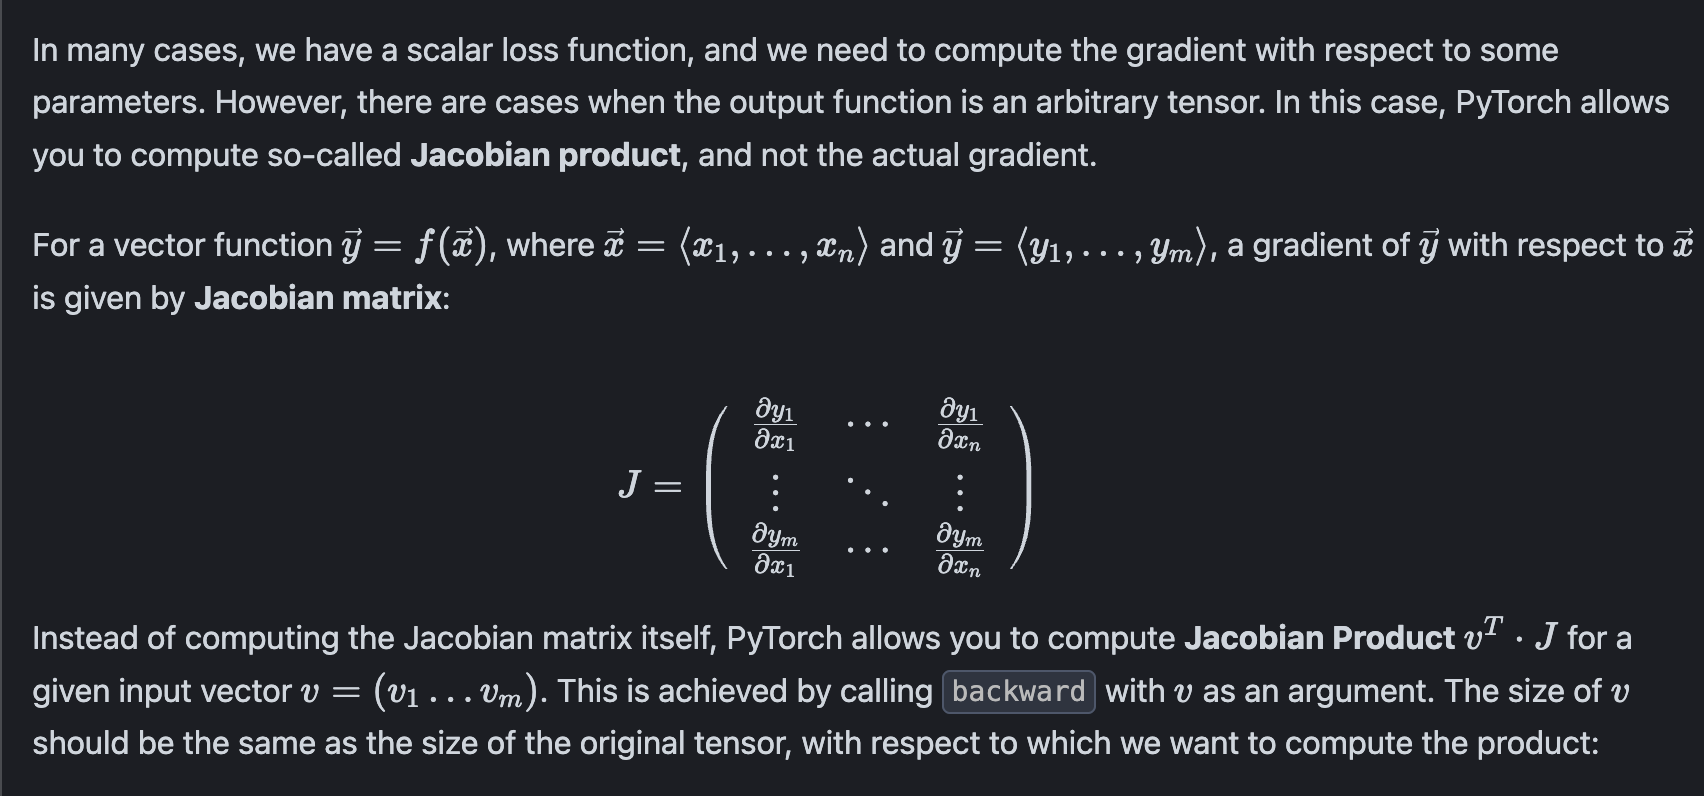

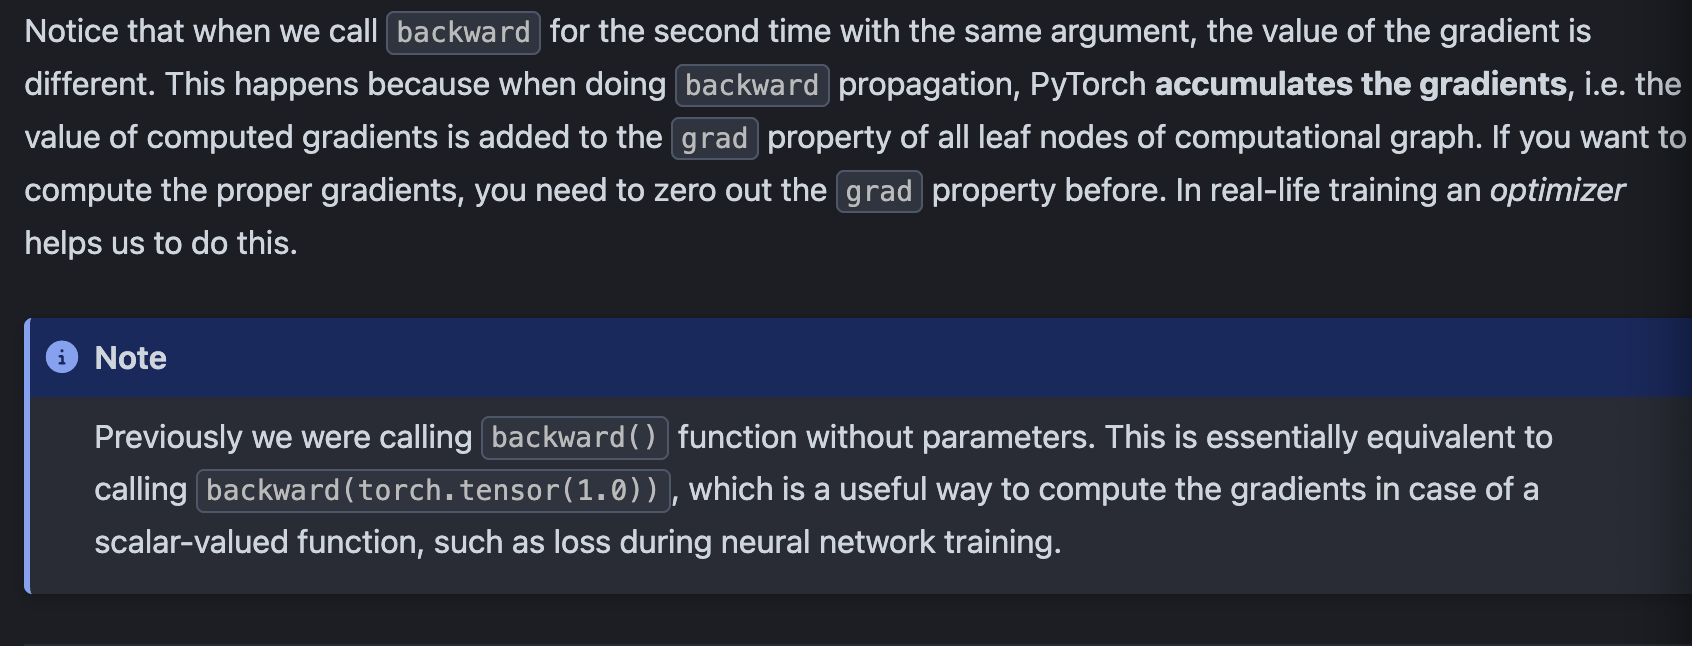